In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

from scipy.signal import savgol_filter

In [2]:
czantoria_full = pd.read_csv('data/csv/czantoria_sauce.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_smooth = savgol_filter(grade_data, 501, 1)

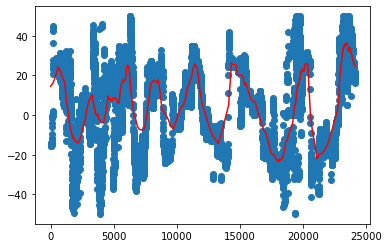

In [5]:
plt.scatter(distance_data, grade_data)
plt.plot(distance_data, grade_smooth, 'r')

In [6]:
grade_data = grade_smooth

print(len(grade_data))

n = distance_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    elif np.sign(grade_data[i+1]) != np.sign(grade_data[i]):
        to_stay[i + 1] = 1
    else:
        to_stay[i + 1] = 1
        
to_stay[-1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]
elevation_data = elevation_data[to_stay == 1]

print(len(grade_data))

13385
505


In [7]:
# n = grade_smooth.shape[0]
# to_stay = np.zeros(n)
# to_stay[0] = 1

# for i in range(n - 1):
#     if (np.abs(grade_smooth[i+1] - grade_smooth[i]) < 15) and (grade_smooth[i+1] * grade_smooth[i] > 0):
#         grade_smooth[i+1] = grade_smooth[i]

In [8]:
grade_data = np.arctan(grade_data/100)

In [9]:
distance = distance_data[-1]

x_data = distance_data/(distance_data[-1])
slope_data = grade_data

In [10]:
# create GEKKO model
m = GEKKO()

In [11]:
t_min = 1 * 60 * 60
t_est = 4 * 60 * 60
t_max = 8 * 60 * 60

In [12]:
# constants
N_m = 0.0222
E0 = 1400
X = distance
tau = 0.67
g = 9.81
k = 0.03734
mass = 55
S = 22

In [13]:
# equation parts
alpha = (np.sqrt(S/tau) * X)/E0
gamma = X/np.sqrt(S * tau**3)
delta = (g*X)/(S*tau)

In [14]:
# scales
u_scale = np.sqrt(S/tau)
v_scale = np.sqrt(S*tau)
t_scale = X/v_scale

In [15]:
# scaled values
sigma0 = 1
e0 = 1
x0 = 0
v0 = 0

e_crit = 0.15 * e0

In [16]:
# slope data to create spline
# x_data = np.linspace(0, 1, 10)
# slope_data = np.array(1*[1/18 * np.pi] + 1 * [-1/18 * np.pi] + 1 *[1/36 * np.pi] + 1 * [-1/36 * np.pi] + 1 * [1/9 * np.pi] + 1*[1/18 * np.pi] + 1 * [-1/18 * np.pi] + 1*[1/36 * np.pi] + 1 * [-1/36 * np.pi] + 1 * [1/9 * np.pi])

In [17]:
# time points [s]
nt = 201
tm = np.linspace(0,1,nt)
m.time = tm

In [18]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=6/v_scale) #velocity
E = m.Var(value=e0, lb=0.0, ub=e0) #energy
x = m.Var(value=0.0) #horizontal coordinate
sigma = m.Const(value=1.0)
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [19]:
tf = m.FV(value=t_est/t_scale, lb = t_min/t_scale, ub=t_max/t_scale)
tf.STATUS = 1

In [20]:
# MV
u = m.MV(value=0,lb=0,ub=9.6/u_scale)
u.STATUS = 1

In [21]:
# slope
m.cspline(x, slope, x_data, slope_data, True)

In [22]:
# equations
m.Equation(E.dt()==(alpha * (sigma - u * v))*tf)
m.Equation(v.dt()==(gamma * (u - v) - delta * m.sin(slope)) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation((distance - X*x)*final<=0)
# m.Equation(sigma - u * v <= 0)

m.fix_final(E, 0)

In [23]:
m.options.IMODE = 6
m.options.MAX_ITER=15000
m.options.SOLVER=3
# m.options.RTOL=1e-4
# m.options.OTOL=1e-4

m.solve()

print('Final Time: ' + str(tf.value[0] * t_scale))

tm = tm * tf.value[0] * t_scale

apm 80.253.213.10_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            1
   Variables    :            8
   Intermediates:            0
   Connections  :            4
   Equations    :            4
   Residuals    :            4
 
 Number of state variables:           2599
 Number of total equations: -         2400
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :             -1
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

  60r 1.1419253e-01 2.09e+04 1.00e+03  -9.0 6.67e-02   4.2 1.00e+00 1.00e+00f  1
  61r 1.1419253e-01 2.09e+04 1.00e+03  -9.0 2.00e-01   3.7 1.00e+00 4.09e-01f  1
  62r 1.1419253e-01 2.09e+04 1.00e+03  -9.0 6.00e-01   3.2 1.00e+00 1.36e-03f  1
  63r 1.1419253e-01 2.09e+04 1.00e+03  -7.5 1.80e+00   2.7 1.00e+00 4.57e-06f  1
  64r 1.1419253e-01 2.09e+04 1.00e+03  -4.9 5.78e+00   2.3 3.30e-04 1.89e-04f  1
  65r 1.1419253e-01 2.09e+04 1.00e+03  -4.9 1.74e+01   1.8 8.05e-05 6.46e-05f  1
  66r 1.1419253e-01 2.09e+04 1.00e+03  -4.9 5.18e+01   1.3 1.71e-05 2.95e-05f  1
  67r 1.1419253e-01 2.09e+04 1.00e+03  -4.9 1.53e+02   0.8 2.24e-06 8.79e-06f  1
  68r 1.1419253e-01 2.09e+04 1.00e+03  -4.9 4.77e+02   0.4 1.52e-06 3.93e-06f  1
  69r 1.1419253e-01 2.09e+04 1.00e+03  -5.0 1.42e+03  -0.1 1.12e-06 1.78e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 1.1419253e-01 2.09e+04 1.00e+03  -5.0 5.33e+02   0.3 9.13e-07 1.40e-06f  1
  71r 1.1419253e-01 2.09e+04

 198r 1.1428516e-01 2.08e+04 1.12e+03  -5.0 7.82e-03   5.2 1.00e+00 6.43e-02f  1
 199r 1.1428516e-01 2.08e+04 1.12e+03  -4.9 2.46e-02   4.7 1.00e+00 4.60e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 1.1428516e-01 2.08e+04 1.12e+03  -4.7 9.24e-03   5.1 1.00e+00 5.69e-02f  1
 201r 1.1428516e-01 2.08e+04 1.12e+03  -4.7 2.77e-02   4.6 1.00e+00 4.21e-02f  1
 202r 1.1428516e-01 2.08e+04 1.12e+03  -4.6 1.04e-02   5.1 1.00e+00 1.09e-01f  1
 203r 1.1428516e-01 2.08e+04 1.12e+03  -4.7 3.11e-02   4.6 1.00e+00 3.81e-02f  1
 204r 1.1428516e-01 2.08e+04 1.12e+03  -4.6 1.16e-02   5.0 1.00e+00 8.99e-02f  1
 205r 1.1428516e-01 2.08e+04 1.13e+03  -4.6 3.55e-02   4.5 1.00e+00 4.36e-02f  1
 206r 1.1428516e-01 2.08e+04 1.13e+03  -4.5 1.43e-02   5.0 1.00e+00 8.52e-02f  1
 207r 1.1428516e-01 2.08e+04 1.13e+03  -4.3 4.35e-02   4.5 1.00e+00 4.99e-02f  1
 208r 1.1428516e-01 2.08e+04 1.13e+03  -4.0 1.69e-01   4.0 1.00e+00 2.14e-02f  1
 209r 1.1428516e-01 2.08e+04

 325  1.4864446e-01 1.83e+04 1.54e+07   2.3 1.77e+03   1.1 6.18e-03 2.69e-03h  1
 326  1.4864446e-01 1.83e+04 1.79e+07  -4.3 1.46e+03   1.5 1.31e-03 8.40e-04h  1
 327  1.4943355e-01 1.83e+04 1.84e+07   2.6 2.99e+03   1.0 2.33e-05 1.93e-03f  1
 328  1.4963288e-01 1.83e+04 2.51e+07   2.6 3.88e+03   1.4 5.57e-03 1.16e-03h  1
 329  1.5160472e-01 1.82e+04 2.57e+07   2.6 3.16e+03   1.0 3.35e-03 4.48e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  1.5160468e-01 1.82e+04 3.30e+07  -4.3 4.25e+03   1.4 5.11e-03 2.80e-04h  1
 331  1.5174551e-01 1.82e+04 3.24e+07   2.6 2.17e+04   0.9 2.80e-05 2.97e-04f  1
 332  1.5178254e-01 1.82e+04 3.21e+07   2.3 5.82e+03   1.3 2.24e-04 3.87e-04f  1
 333  1.5180238e-01 1.81e+04 2.87e+07   1.8 5.37e+03   1.8 9.96e-05 1.56e-03h  1
 334  1.5180644e-01 1.81e+04 2.89e+07   2.6 4.36e+03   1.3 1.50e-03 1.76e-05h  1
 335  1.5409998e-01 1.81e+04 2.89e+07   2.6 1.12e+04   0.8 9.11e-04 4.09e-03f  1
 336  1.5436308e-01 1.80e+04

 427  2.5142811e-01 1.22e+03 8.47e+03   0.2 1.91e+03  -0.7 1.04e-02 3.16e-03h  1
 428  2.5153605e-01 1.21e+03 7.52e+03   0.2 1.82e+03  -1.2 1.29e-03 1.68e-03h  1
 429  2.5196929e-01 1.21e+03 1.56e+04   0.2 2.06e+03  -1.6 4.22e-03 4.88e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  2.5316554e-01 1.19e+03 1.33e+05   0.2 2.12e+03  -1.2 3.74e-04 1.77e-02h  1
 431  2.5319258e-01 1.19e+03 1.32e+05   0.2 2.78e+03  -1.7 1.05e-02 2.97e-04h  1
 432  2.5326065e-01 1.18e+03 1.32e+05   0.2 1.13e+04  -2.2 1.38e-03 6.48e-04h  1
 433  2.5328598e-01 1.18e+03 1.32e+05   0.2 2.36e+03  -1.7 3.40e-03 2.70e-04h  1
 434  2.5399445e-01 1.17e+03 1.27e+05   0.2 2.03e+03  -1.3 3.03e-03 9.55e-03h  1
 435  2.5399659e-01 1.17e+03 1.27e+05   0.2 4.72e+03  -1.8 1.39e-03 2.24e-05h  1
 436  2.5420300e-01 1.17e+03 1.27e+05   0.2 1.31e+04  -2.3 4.12e-04 1.97e-03f  1
 437  2.5429380e-01 1.17e+03 1.27e+05   0.2 2.16e+03  -1.8 8.05e-03 9.34e-04h  1
 438  2.5543779e-01 1.16e+03

 528  3.3369061e-01 6.50e+02 7.92e+04   0.2 8.09e+02  -1.0 2.89e-02 5.82e-04h  1
 529  3.3456595e-01 6.45e+02 7.77e+04   0.2 1.35e+03  -1.5 8.89e-03 7.91e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  3.3721925e-01 6.18e+02 8.62e+04   0.2 9.61e+02  -1.1 1.46e-02 4.17e-02h  1
 531  3.3775243e-01 6.07e+02 8.03e+04   0.2 3.58e+02  -0.6 3.69e-03 1.80e-02f  1
 532  3.3783045e-01 6.07e+02 8.04e+04   0.2 4.80e+02  -1.1 6.22e-02 1.14e-03h  1
 533  3.3790400e-01 6.06e+02 8.04e+04   0.2 6.38e+03  -1.6 1.02e-03 5.86e-04h  1
 534  3.3871473e-01 6.00e+02 9.04e+04   0.2 6.15e+02  -1.2 4.79e-03 1.08e-02h  1
 535  3.3925162e-01 5.97e+02 9.09e+04   0.2 8.58e+02  -1.6 2.23e-02 4.08e-03h  1
 536  3.3997512e-01 5.95e+02 9.08e+04   0.2 3.91e+03  -2.1 1.15e-02 4.06e-03h  1
 537  3.4073814e-01 5.92e+02 9.07e+04   0.2 8.57e+02  -1.7 3.06e-03 5.46e-03h  1
 538  3.4253447e-01 5.86e+02 9.06e+04   0.2 2.10e+03  -2.2 5.22e-03 9.79e-03h  1
 539  3.4349822e-01 5.82e+02

 621  2.2560874e-04 1.05e-07 1.33e-07  -9.3 6.88e-03  -5.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 621

                                   (scaled)                 (unscaled)
Objective...............:   2.2560874472416759e-04    2.2560874472416759e-04
Dual infeasibility......:   1.3274844588102675e-07    1.3274844588102675e-07
Constraint violation....:   4.6241966484906305e-08    1.0463896416013085e-07
Complementarity.........:   7.5219066766687386e-10    7.5219066766687386e-10
Overall NLP error.......:   1.3274844588102675e-07    1.3274844588102675e-07


Number of objective function evaluations             = 719
Number of objective gradient evaluations             = 327
Number of equality constraint evaluations            = 719
Number of inequality constraint evaluations          = 719
Number of equality constraint Jacobian evaluations   = 626
Number of inequality constraint Jacobian evaluations = 626
Number of Lagrangian Hessian evaluations             = 621
Total CPU secs i

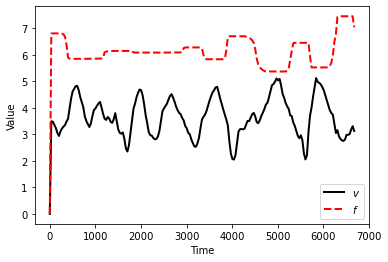

In [24]:
plt.figure(1)
plt.plot(tm,np.array(v.value) * v_scale,'k-',lw=2,label=r'$v$')
plt.plot(tm,np.array(u.value) * u_scale,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

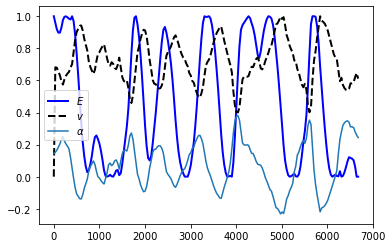

In [25]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

In [26]:
5496.557240864244
5470.811627159549

5470.811627159549